In [1]:
import sys
sys.path.append("..")   # this allows us to import from sibling directory

import matplotlib.pyplot as plt  
import sklearn
from code_to_import.dataset_preprocessing import ProductionModeDataset

import torch
# from sklearn.inspection import permutation_importance
import numpy as np
import uproot
import torch.nn as nn
from matplotlib import pyplot as plt

from skorch import NeuralNetClassifier

from code_to_import.Classifier_module import GCN4Layers
from torch.autograd import Variable
import dgl


Using backend: pytorch


In [458]:
################# THIS IS WHERE YOU CHOOSE WHAT TO LOAD ################################

correlation_cut = -1   # if negative none, current other options are 0.9 and 0.8, but more can be added

cut_version = -1   # -1 means OG, otherwise can be 2 or 3 (or more if added)

event_type = "ee"  # could be ee, emu, mumu

weight_cmd = "true"   # could also be "false", "true" or "no-neg"

drop = 0.2  # drop rate

input_type = "allorentz_gen"

qg_cmd = False

batch_size = 2000


layer_number = "five"
layer_num_type = "more"

#This is only here in case format is changed... should be good for all three layer stuff otherwise
model_name = "GNN_Model4Layers_V1_" + event_type + "_corrCut_" + str(correlation_cut) + "_weights_" + weight_cmd + "_drop_" + str(drop)

if cut_version > 0:
    model_name += "cutV" + str(cut_version)

if input_type != "all":
    model_name += "_" + input_type
    
if not qg_cmd:
    model_name += "_no_qg"
    

model_name += "batch" + str(batch_size)

In [459]:
model_name

'GNN_Model4Layers_V1_ee_corrCut_-1_weights_true_drop_0.2_allorentz_gen_no_qgbatch2000'

In [460]:

    
# root_path = "/depot-new/cms/top/mcnama20/TopSpinCorr-Run2-Entanglement/CMSSW_10_2_22/src/TopAnalysis/Configuration/analysis/diLeptonic/three_files/Nominal"

# file = root_path + "/" + event_type + "_modified_root_1_spinCorr.root"

path_to_model = "../models/" + "GNN/" + model_name + ".pt"

title = "confusion_plot_" + model_name

In [461]:
alt_name = "GNN_Model1_ee_corrCut_-1_weights_true_drop_0.2_allorentz_gen_no_qg"

In [520]:
############### Create a production mode dataset object and get the validation dataset.############################
################## NOTE: THIS NEEDS TO BE REPLACED BY LOADING THE SAVED DATASET FOR MODEL #########################
# data_object = ProductionModeDataset(file)
# x = data_object.get_eval_data()

train = np.load("../data/" + "GNN/train_val_datasets/training_dataset_" + model_name + ".npy", allow_pickle=True)


In [521]:
train_target = train[1]

(array([42257.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 42395.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

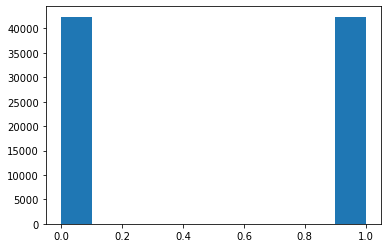

In [523]:
plt.hist(train_target)

(array([10651.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 10512.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

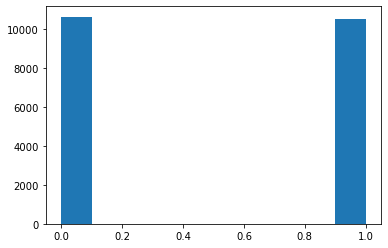

In [517]:
plt.hist(target)

In [464]:
####################################### load data for evaluation of model (not training set) and separate weights and target
validation_data = x[0]

y_val = validation_data
val_data = torch.reshape(y_val, (10 * y_val.shape[0], 4))
                    
# # replace all negative weighted events with zero if the weight_cmd says to
# if opt.weight_cmd == "no-neg":
#     w_val[w_val < 0] = 0

# # remove weighting (aka, set all to 1) if weight_cmd says to
# if opt.weight_cmd == "false":
#     w_val = np.ones(w_val.shape)
    
# w_val = Variable(torch.from_numpy(w_val).type(torch.FloatTensor))




In [465]:
############################## Load the model and run eval so we know to evaluate ##################################
# try:
#     model = Classifier()
#     model.load_state_dict(torch.load(path_to_model))
# except:
model = GCN4Layers(4,2)
model.load_state_dict(torch.load(path_to_model))
model.eval()

GCN4Layers(
  (conv1): GraphConv(in=4, out=128, normalization=both, activation=None)
  (conv2): GraphConv(in=128, out=64, normalization=both, activation=None)
  (conv3): GraphConv(in=64, out=32, normalization=both, activation=None)
  (conv4): GraphConv(in=32, out=2, normalization=both, activation=None)
)

In [466]:
# build up version
        up_source = torch.tensor([6, 7, 8, 9, 2, 3, 4, 5])
        up_range =  torch.tensor([3, 3, 4, 4, 0, 0, 1, 1])
        
        # build down version
        down_source = torch.tensor([3, 3, 4, 4,  0, 0, 1, 1])
        down_range = torch.tensor([6, 7, 8, 9, 2, 3, 4, 5])
        
        # similar type connection
        sim_source = torch.tensor([6, 8, 7, 9, 2, 5, 3, 4, 0, 1])
        sim_range = torch.tensor([8, 6, 9, 7, 5, 2, 4, 3, 1, 0])
        
        # same parent
        child_source = torch.tensor([6, 7, 8, 9, 2, 3, 4, 5])
        child_range = torch.tensor([7, 6, 9, 8, 3, 2, 5, 4])
        
        ############### for now I will include building up and both similar and same parent TODO: add parameter to determine
        # this
        source_ids = torch.cat((up_source, sim_source, child_source))
        range_ids = torch.cat((up_range, sim_range, child_range))
        graph = dgl.graph((source_ids, range_ids), num_nodes=10)
        graph = dgl.add_self_loop(graph)


In [467]:
# val_graphs = graph

# for i in range(y_val.shape[0] - 1):
#     val_graphs = dgl.batch([val_graphs, graph])

In [468]:
val_graphs

Graph(num_nodes=211630, num_edges=761868,
      ndata_schemes={'h': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={})

In [469]:
softmax = torch.nn.Softmax(dim=1)

In [493]:
input = val_data

d = model(val_graphs, input)
data = softmax(d)
data = data[:,1]
data = data.detach().numpy()

In [494]:
data

array([0.41617447, 0.42043096, 0.510787  , ..., 0.519376  , 0.4707027 ,
       0.4301585 ], dtype=float32)

In [495]:
model(val_graphs, input).detach().numpy()


array([[-0.4568689 , -0.79536647],
       [-0.4336466 , -0.7546512 ],
       [-0.6269774 , -0.58382255],
       ...,
       [-0.6339536 , -0.5564108 ],
       [-0.5377411 , -0.6550648 ],
       [-0.47450575, -0.7557103 ]], dtype=float32)

In [496]:
target = x[1]

In [497]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(target, data) # sample_weight = weight)
auroc = sklearn.metrics.auc(fpr, tpr)

In [498]:
auroc

0.5925108932111618

In [499]:
fpr

array([0.        , 0.        , 0.        , ..., 0.99971834, 0.99971834,
       1.        ])

In [500]:
tpr

array([0.00000000e+00, 9.51293760e-05, 1.14155251e-03, ...,
       9.99904871e-01, 1.00000000e+00, 1.00000000e+00])

In [501]:
thresholds

array([1.930046  , 0.93004596, 0.8868138 , ..., 0.3798789 , 0.3789899 ,
       0.37561986], dtype=float32)

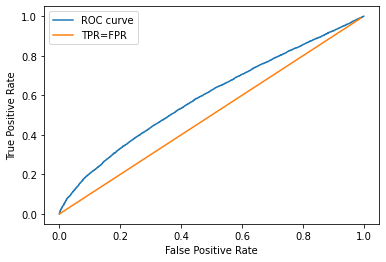

In [502]:
plt.plot(fpr, tpr, label='ROC curve')
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), label='TPR=FPR')
plt.legend()


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

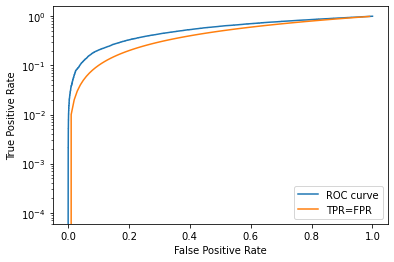

In [503]:
plt.plot(fpr, tpr, label='ROC curve')
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), label='TPR=FPR')
plt.legend()
plt.yscale('log')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

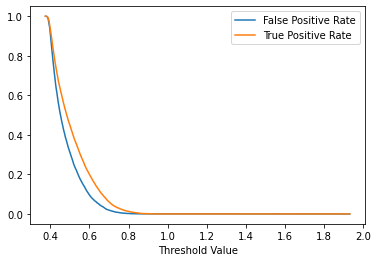

In [504]:

plt.plot(thresholds, fpr, label='False Positive Rate')
plt.plot(thresholds, tpr, label='True Positive Rate')
plt.xlabel('Threshold Value')
plt.legend()
plt.show()

In [505]:
max(data)

0.93004596

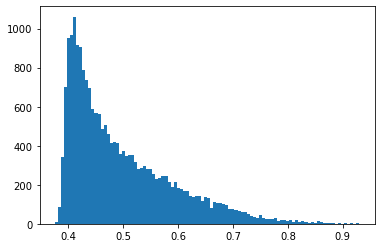

In [506]:
plt.hist(data, bins = 100)
# plt.yscale('log')

ax = plt.gca()
# ax.set_xlim(0.0, 1.0)

plt.show()

In [507]:
y_pred_test =  Variable(torch.from_numpy(data))

In [508]:
max(y_pred_test)

tensor(0.9300)

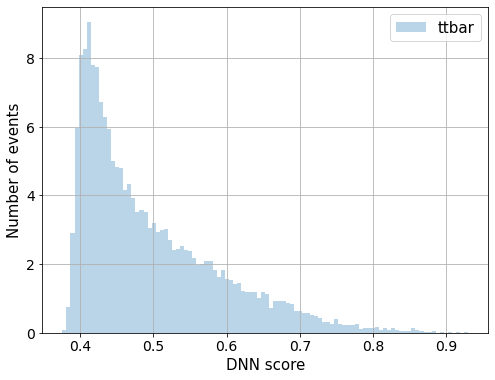

In [509]:
# # Predictions for signal and background
# tt_pred  = model.predict(tt_df_test) 
# si_pred  = model.predict(sig_df_test)

# # Set binning, tick size
binning = np.linspace(-1, 1, 20)
plt.figure(figsize=(8,6))
plt.tick_params(axis="y", labelsize=14)
plt.tick_params(axis="x", labelsize=14)

# Now plot the model outputs
plt.hist(data, alpha=0.3, label='ttbar', density=True, bins = 100)
# plt.hist(si_pred, bins=binning, alpha=0.3, label='SUSY all', density=True)
#plt.yscale('log')
# plt.xlim(0,1)
plt.xlabel('DNN score', fontsize=15)
plt.ylabel('Number of events', fontsize=15)
plt.grid()
plt.legend(loc='best', fontsize=15)
#plt.savefig('DNN score Mstop_235 Mchi_60.jpg')

In [510]:
y_pred_test = y_pred_test.reshape(len(y_pred_test))
y_pred_test

tensor([0.4162, 0.4204, 0.5108,  ..., 0.5194, 0.4707, 0.4302])

In [511]:
target.shape

(21163,)

In [512]:
class_0_mask = torch.BoolTensor(target == 0)
class_1_mask = torch.BoolTensor(target == 1)

class_0_predictions = torch.masked_select(y_pred_test, class_0_mask).detach().numpy()
class_1_predictions = torch.masked_select(y_pred_test, class_1_mask).detach().numpy()

In [513]:
class_0_predictions

array([0.510787  , 0.4353059 , 0.40338808, ..., 0.43744507, 0.519376  ,
       0.4707027 ], dtype=float32)

(array([3559., 2946., 1671., 1087.,  703.,  393.,  188.,   70.,   24.,
          10.]),
 array([0.37561986, 0.42646992, 0.47731996, 0.52817   , 0.57902   ,
        0.6298701 , 0.68072015, 0.7315702 , 0.7824203 , 0.8332703 ,
        0.88412035], dtype=float32),
 <BarContainer object of 10 artists>)

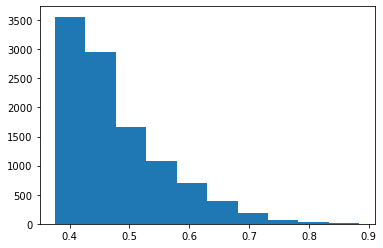

In [514]:
plt.hist([class_0_predictions], stacked=True)#, bins = 100)
# plt.yscale('log')

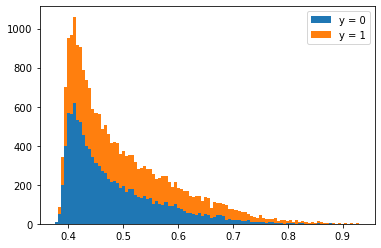

In [515]:
plt.hist([class_0_predictions, class_1_predictions], stacked=True, label=['y = 0', 'y = 1'], bins = 100)
# plt.hist(y_pred_test[test_labels == 0], color='red', label='$\hat{y} = 0', bins=10)
# plt.yscale('log')

# ax = plt.gca()
# ax.set_xlim(0.0, 1.0)

plt.legend()
plt.show()

In [524]:
d

tensor([[-0.4569, -0.7954],
        [-0.4336, -0.7547],
        [-0.6270, -0.5838],
        ...,
        [-0.6340, -0.5564],
        [-0.5377, -0.6551],
        [-0.4745, -0.7557]], grad_fn=<DivBackward0>)

In [525]:
criterion = nn.CrossEntropyLoss(reduction='none')# this is the loss function. reduction='none' makes it return a value for each input (reduce=False was deprecated)

In [553]:
w_val = x[2]
w_val

array([0.86724532, 0.86724532, 0.59378856, ..., 1.        , 0.86724532,
       0.9932525 ])

In [537]:
target = torch.from_numpy(target)

In [540]:
target = Variable(target.type(torch.LongTensor))

In [548]:
output = criterion(d, target)

In [557]:
w_val = np.double(w_val)

In [558]:
w_val

array([0.86724532, 0.86724532, 0.59378856, ..., 1.        , 0.86724532,
       0.9932525 ])

In [559]:
w_val = torch.from_numpy(w_val)

In [560]:
w_val = w_val.type(torch.DoubleTensor)

In [561]:
w_val

tensor([0.8672, 0.8672, 0.5938,  ..., 1.0000, 0.8672, 0.9933],
       dtype=torch.float64)

In [565]:
np.dot(w_val.detach().numpy(), criterion(d, target).detach().numpy())/(target.shape[0]) 

0.561944577611238